In [ ]:
import pandas as pd
import numpy as onp
import matplotlib.pyplot as plt
import librosa
import os
import sys
import librosa.display 
import scipy
import jax.numpy as np
import decimal as dc
import math
import logging
from scipy.fftpack import dct
from scipy.io import wavfile as wav
from scipy.io.wavfile import write, read
from scipy.signal import get_window
from scipy.linalg import circulant
from scipy.linalg import hankel
import IPython.display as ipd
from IPython.display import clear_output
from __future__ import division

In [ ]:
!nvidia-smi

Thu Jun  4 23:13:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
!pip install wavio
!git clone https://github.com/juliagusak/dataloaders
sys.path.append('dataloaders/')
clear_output()

In [ ]:
os.chdir('/content/dataloaders')
os.makedirs('/content/datasets/esc')
!python esc/esc_gen.py /content/datasets/esc
clear_output()

In [ ]:
from esc import ESCDatasets

In [ ]:
pip install pydmd

In [ ]:
from pydmd import DMD, HODMD, MrDMD

#PART 1: DMD Audio Feature Extraction 

### Creating a sample audio signal for test :

-  An audio signal can be represented by a series of measurements
$y_{t}$ at constant time intervals $t = k\Delta t$ 

- and over a short time frame, the signal is formed by superimposing $N$ simple oscillators with angular frequencies  $w_{j=1}^{N}$ and complex amplitudes $A_{j=1}^{N}$

- such that: $y_{t} = Re \left( \sum_{j=1}^{N} A_{j} exp(iw_{j}k\Delta t) \right)$

In [ ]:
t = np.linspace(0,10,128)    #give me 128 exactly spaced samples between 0 and (N)                             
x = np.linspace(1, 128, 128)  


Amp = (2+1j)*x              #complex amplitude and frequency
Freq = np.exp(2.5j*x*t)     

N = 128                      #evaluate y_t for N=128 
for i in range(1,N):
  yt = sum(Amp*Freq)


y_real = yt.real             #get real part of y
y_real  

-368.9204890727997

- computing audio signal vector $z_{y}$ from the $y_{t}$ above

- such that $z_{t} = \left[ y_{t}......y_{t+2N-1} \right]$

- Its important to delay observations with at least $2N$ in order to detect $N$ frequencies

In [ ]:
def frange(start, stop, step=1.0):
    i = start
    while i < stop:
        yield i
        i += step

get_list = list(frange(y_real,y_real+(2*N),1))  
zt = np.asarray(get_list,dtype=np.float32)
len(zt)        

256

In [ ]:
zt[:10]

DeviceArray([-368.9205, -367.9205, -366.9205, -365.9205, -364.9205,
             -363.9205, -362.9205, -361.9205, -360.9205, -359.9205],            dtype=float32)

- Arranging $z_{t}$ and its time-shifted version as columns of two bigger matrices

- Using Henkel matrix contruction

- such that: 

- $Z_{t} = \left[ z_{t}......z_{t+N-1} \right]$

- $Z_{t + 1} = \left[z_{t+1}......z_{t+N} \right]$

In [ ]:
ZZT = hankel(zt,zt)
ZZT.shape

(256, 256)

In [ ]:
ZZT[:5,:5].T[np.newaxis]

array([[[-368.9205, -367.9205, -366.9205, -365.9205, -364.9205],
        [-367.9205, -366.9205, -365.9205, -364.9205, -363.9205],
        [-366.9205, -365.9205, -364.9205, -363.9205, -362.9205],
        [-365.9205, -364.9205, -363.9205, -362.9205, -361.9205],
        [-364.9205, -363.9205, -362.9205, -361.9205, -360.9205]]],
      dtype=float32)

In [ ]:
ZZt = ZZT[:,:64]           #get 1st 64 columns into the new matrix...
ZZt_shift = ZZT[:,1:65]    ##from the 2nd column to the 65th column...(time shifted version of 1st matrix)

print(ZZt.shape) 
print(ZZt_shift.shape)                     

(256, 64)
(256, 64)


- Compute the Matrix to apply DMD on:

- $K_{t} = Z_{t+1}Z_{t}^{+}$

In [ ]:
ZZT_PINV = np.linalg.pinv(ZZt)    #Calculate the peudoinverse of Zt
KT = onp.matmul(ZZt_shift,ZZT_PINV)  ####compute Matrix to compute DMD on

In [ ]:
KT

array([[ 8.5877562e-03,  8.5660890e-03,  8.5444208e-03, ...,
         1.3319136e-03,  1.3331012e-03,  1.3327643e-03],
       [ 8.5660191e-03,  8.5444171e-03,  8.5228104e-03, ...,
         1.3162800e-03,  1.3175179e-03,  1.3171284e-03],
       [ 8.5442821e-03,  8.5227424e-03,  8.5012037e-03, ...,
         1.3006469e-03,  1.3019347e-03,  1.3014933e-03],
       ...,
       [ 1.3488539e-03,  1.3327200e-03,  1.3173055e-03, ...,
        -1.5399697e-04,  9.9984914e-01, -1.5272570e-04],
       [ 1.3496131e-03,  1.3328668e-03,  1.3173044e-03, ...,
        -1.5365639e-04, -1.5132660e-04,  9.9984688e-01],
       [ 8.5877562e-03,  8.5660890e-03,  8.5444208e-03, ...,
         1.3319136e-03,  1.3331012e-03,  1.3327643e-03]], dtype=float32)

####Applying Higher Order DMD  on the Matrix above;

In [ ]:
pip install pydmd

In [ ]:
from pydmd import DMD, HODMD, MrDMD

In [ ]:
h_ODMD = HODMD(svd_rank=0,exact=True,opt=True,d=30)   #Truncated SVD version, with optimal set of eigenvalues  
h_ODMD.fit(KT)                                         #exact DMD , 1D signal should be imported directly without the matrix. HODMD can handle it

In [ ]:
h_modes = h_ODMD.modes                #each columm represent a single mode ... 
h_dynamics = h_ODMD.dynamics          #each row represents a single dynamic pattern..
print("Shape of Mode Matrix: ", h_modes.shape)
print("Shape of Dynamics Matrix: ", h_dynamics.shape)

Shape of Mode Matrix:  (256, 105)
Shape of Dynamics Matrix:  (105, 256)


Number  of Eigenvalues:  105




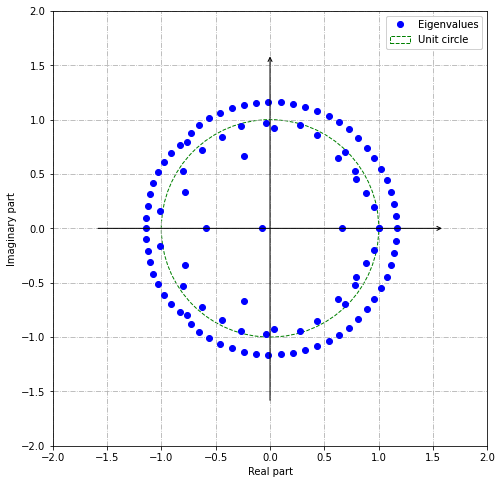

In [ ]:
                                          ##plot of Eigen values and viewing mode stability
print("Number  of Eigenvalues: ", len(h_ODMD.eigs))
print("\n")
h_ODMD.plot_eigs()

- Stable modes have eigenvales on the unit circle

### Computing Frequency from the Eigen values:


- The eigenvalue $\lambda_{j}$ corresponds to the temporal dynamics of each spatial mode $\phi_{j}$

- Specifically its rate of growth/decay and frequency of oscillation 
are reflected in the magnitude and phase components of the eigenvalues

- The magnitude of the eigenvalues relative to
the unit circle indicates whether the corresponding
mode is growing or decaying

- The phase of each eigenvalue translates to the frequency of oscillation.
and its computed as;

- $f_{j} =  \frac{1}{2 \pi \Delta t}  Imag(log \lambda_{j}) $



In [ ]:
print("The Eigenvalues of KT are given as: ")
eigens = h_ODMD.eigs
eigens

The Eigenvalues of KT are given as: 


array([-1.1436214 +0.j        , -1.1385732 +0.09969369j,
       -1.1385732 -0.09969369j, -1.12506   +0.205932j  ,
       -1.12506   -0.205932j  , -1.1062753 +0.31273732j,
       -1.1062753 -0.31273732j, -1.0758944 +0.41532624j,
       -1.0758944 -0.41532624j, -1.0327008 +0.5141898j ,
       -1.0327008 -0.5141898j , -0.97764754+0.60881263j,
       -0.97764754-0.60881263j, -0.9121795 +0.69648105j,
       -0.9121795 -0.69648105j, -0.8323571 +0.7701111j ,
       -0.8323571 -0.7701111j , -0.7284075 +0.87621516j,
       -0.7284075 -0.87621516j, -0.6488928 +0.9514726j ,
       -0.6488928 -0.9514726j , -0.5572425 +1.0127742j ,
       -0.5572425 -1.0127742j , -0.45698535+1.063676j  ,
       -0.45698535-1.063676j  , -0.7654803 +0.79621357j,
       -0.7654803 -0.79621357j, -0.35066184+1.104582j  ,
       -0.35066184-1.104582j  , -1.0083886 +0.16414389j,
       -1.0083886 -0.16414389j, -0.24047798+1.1356989j ,
       -0.24047798-1.1356989j , -0.12848113+1.1553055j ,
       -0.12848113-1.1553055j ,

In [ ]:
    #get freqncies from eigenvalues
def get_freq(eigens):
  freq = ((onp.log(eigens)).imag)/(2*np.pi)
  return freq

freq = get_freq(eigens)  
freq

array([ 0.5       ,  0.4860998 , -0.4860998 ,  0.47118708, -0.47118708,
        0.45615202, -0.45615202,  0.44136658, -0.44136658,  0.4264748 ,
       -0.4264748 ,  0.41135594, -0.41135594,  0.3962139 , -0.3962139 ,
        0.38117906, -0.38117906,  0.36038092, -0.36038092,  0.34525976,
       -0.34525976,  0.33005613, -0.33005613,  0.31458256, -0.31458256,
        0.3718683 , -0.3718683 ,  0.29892394, -0.29892394,  0.47431827,
       -0.47431827,  0.28320962, -0.28320962,  0.26762712, -0.26762712,
        0.25196627, -0.25196627,  0.23628508, -0.23628508,  0.22063372,
       -0.22063372,  0.20486027, -0.20486027,  0.18917552, -0.18917552,
        0.17373689, -0.17373689,  0.1584131 , -0.1584131 ,  0.14304318,
       -0.14304318,  0.12717628, -0.12717628,  0.1108868 , -0.1108868 ,
        0.09467147, -0.09467147,  0.04679373, -0.04679373,  0.        ,
        0.01558395, -0.01558395,  0.03107341, -0.03107341,  0.06263383,
       -0.06263383,  0.0785719 , -0.0785719 ,  0.40733767, -0.40

Text(0.5, 1.0, 'Plot of Frequency gotten from DMD')

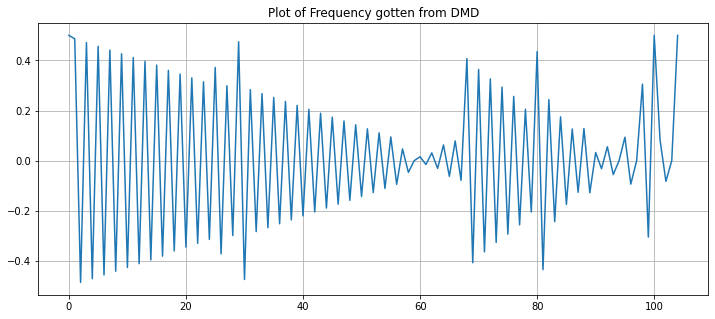

In [ ]:
        #plot of thr DMD frequency...
plt.figure(figsize=(12,5))
plt.plot(freq)
plt.grid()
plt.title("Plot of Frequency gotten from DMD")

### Computing DMD spectrum from spatial Modes

- The maginitude of each mode represents spatial correlations between the observable n locations.

- and the power spectrum can be computed from these mode;

- such that ; DMD Power spectrum = $||Mode||^2$


In [ ]:

def get_spectrum(HODMD_modes):
  Mode_Mags =  np.sum(np.abs(HODMD_modes.T)**2,axis=-1)**(1./2) ##magnitude of each mode....
  DMD_Spectrum = (Mode_Mags)**2
  return DMD_Spectrum


DMD_Spectrum = get_spectrum(h_modes)  
print("lenght of spectrum :" , len(DMD_Spectrum))
DMD_Spectrum

lenght of spectrum : 105


DeviceArray([1.28282671e-04, 1.32116504e-04, 1.32116504e-04,
             1.27609223e-04, 1.27609223e-04, 9.88308602e-05,
             9.88308602e-05, 8.44495880e-05, 8.44495880e-05,
             8.31462967e-05, 8.31462967e-05, 9.03264372e-05,
             9.03264372e-05, 1.07628846e-04, 1.07628846e-04,
             1.94698252e-04, 1.94698252e-04, 1.53743560e-04,
             1.53743560e-04, 9.04609406e-05, 9.04609406e-05,
             7.51984626e-05, 7.51984626e-05, 6.97318901e-05,
             6.97318901e-05, 6.90161134e-04, 6.90161134e-04,
             6.61750018e-05, 6.61750018e-05, 1.53973838e-02,
             1.53973838e-02, 6.07354777e-05, 6.07354777e-05,
             5.68166943e-05, 5.68166943e-05, 5.50055120e-05,
             5.50055120e-05, 5.25919386e-05, 5.25919386e-05,
             5.12203878e-05, 5.12203878e-05, 4.99444723e-05,
             4.99444723e-05, 4.57744827e-05, 4.57744827e-05,
             4.31734625e-05, 4.31734625e-05, 4.37521412e-05,
             4.37521412e

Text(0.5, 1.0, 'Plot of Spectrum gotten from DMD')

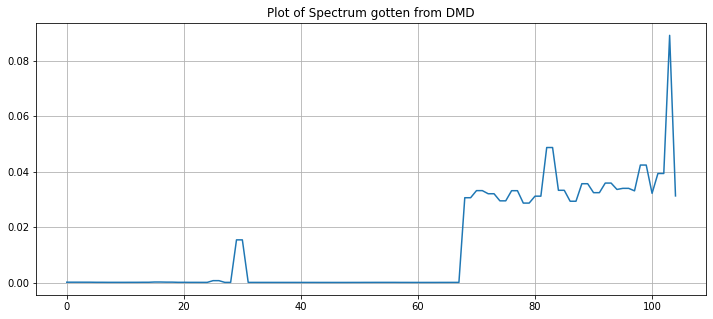

In [ ]:
        #plot of thr DMD frequency...
plt.figure(figsize=(12,5))
plt.plot(DMD_Spectrum)
plt.grid()
plt.title("Plot of Spectrum gotten from DMD")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


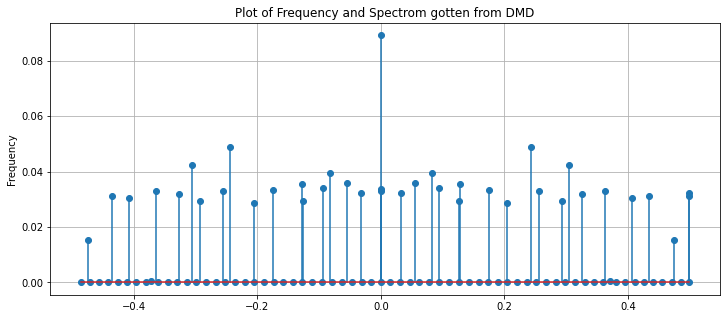

In [ ]:
        #plot of thr DMD frequency...
fig, ax = plt.subplots(figsize=(12,5))
ax.stem(freq,DMD_Spectrum,)
plt.grid()
plt.title("Plot of Frequency and Spectrom gotten from DMD")
plt.ylabel("Power Spectrum")
plt.ylabel("Frequency")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=105).
  """Entry point for launching an IPython kernel.


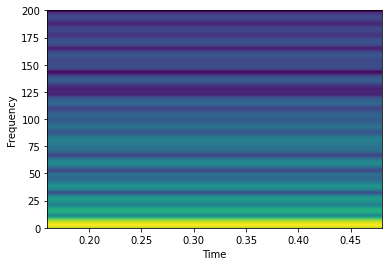

<Figure size 864x720 with 0 Axes>

In [ ]:
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(DMD_Spectrum, Fs=400)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.figure(figsize=(12,10))
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=105).
  """Entry point for launching an IPython kernel.


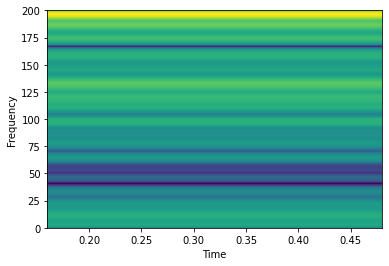

<Figure size 864x720 with 0 Axes>

In [ ]:
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(freq, Fs=400)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.figure(figsize=(12,10))
plt.show()

###Application with real audio signal

sampling rate: 22050
wav shape: (110250,)


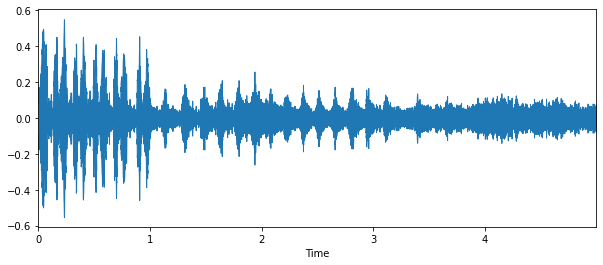

In [ ]:
#print("Bird_chirping...")
dir_2 =  "/content/datasets/esc/esc50/ESC-50-master/audio/1-100038-A-14.wav"
plt.figure(figsize=(10,4))
data_bird,sample_rate = librosa.load(dir_2)
print('sampling rate:', sample_rate)
print('wav shape:', data_bird.shape)
_ = librosa.display.waveplot(data_bird,sr=sample_rate)
ipd.Audio(dir_2)

(441,)


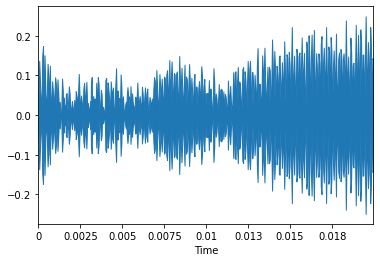

In [ ]:
                                #sampling out ...2milli seconds of the data for testing
bird_1s=data_bird[:441]
print(bird_1s.shape)
_ = librosa.display.waveplot(bird_1s,sr=sample_rate)

- Now I will be getting an appropriate matrix to act DMD on from the audio Signal 

- Same procedure as for the sample signal test

In [ ]:
MAT_data = hankel(bird_1s,bird_1s)
print(MAT_data.shape)
MAT_data[:4,:4]

(441, 441)


array([[-0.02941924, -0.13688716, -0.08337966, -0.03774157],
       [-0.13688716, -0.08337966, -0.03774157,  0.01642091],
       [-0.08337966, -0.03774157,  0.01642091,  0.14860964],
       [-0.03774157,  0.01642091,  0.14860964,  0.17393196]],
      dtype=float32)

In [ ]:
bird_MAT =      MAT_data[:,:64]    ###get 1st 64 columns into the new matrix...
bird_MAT_step = MAT_data[:,1:65]    ##from [z_t+1 ......z_t+N]
print ("Shape of augumented matrix: ", bird_MAT.shape)                         ##from the 2nd column to the 65th column  
print ("Shape of time_shifted matrix: ", bird_MAT_step.shape)                         

Shape of augumented matrix:  (441, 64)
Shape of time_shifted matrix:  (441, 64)


In [ ]:
bird_MAT_PINV = np.linalg.pinv(bird_MAT)    #Calculate the peudoinverse the original matrix
DMD_MAT = onp.matmul(bird_MAT_step,bird_MAT_PINV)  ####compute Matrix to compute DMD on
DMD_MAT

array([[ 0.00716158,  0.18238585,  0.00755721, ...,  0.00110453,
        -0.0207803 ,  0.02055571],
       [-0.01510592,  0.00755704,  0.1790809 , ...,  0.0023201 ,
         0.00462686, -0.0324421 ],
       [ 0.03705008, -0.01829446,  0.01278509, ..., -0.02524166,
        -0.00127981,  0.01496531],
       ...,
       [ 0.02120004, -0.02078025,  0.0046269 , ...,  0.07242796,
         0.30919752,  0.08158641],
       [ 0.15695445,  0.02055553, -0.03244219, ..., -0.03062946,
         0.08158658,  0.21603549],
       [ 0.00716158,  0.18238585,  0.00755721, ...,  0.00110453,
        -0.0207803 ,  0.02055571]], dtype=float32)

- Applying HODMD on the matrice computed above:

In [ ]:
h_ODMD = HODMD(svd_rank=0,exact=True,opt=True)
h_ODMD.fit(DMD_MAT)

In [ ]:
h_modes = h_ODMD.modes            #modes....
h_dynamics = h_ODMD.dynamics      #dynamics.....
print(h_modes.shape)
print(h_dynamics.shape)

(441, 81)
(81, 441)


Number  of Eigenvalues:  81




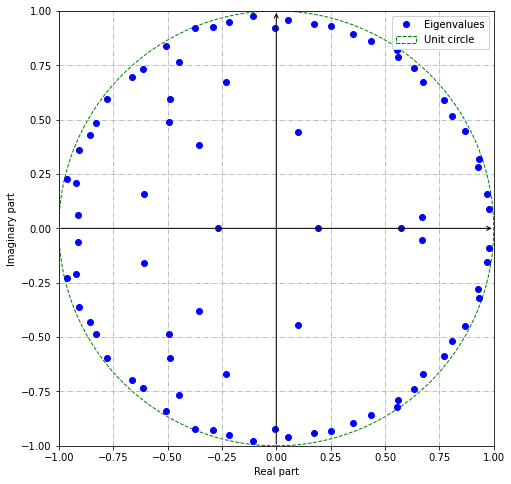

In [ ]:
                                          ##plot of Eigen values and viewing mode stability
print("Number  of Eigenvalues: ", len(h_ODMD.eigs))
print("\n")
h_ODMD.plot_eigs()

In [ ]:
eigens = h_ODMD.eigs
freq = get_freq(eigens)  
freq

array([ 0.01455477, -0.01455477,  0.02558217, -0.02558217,  0.05286   ,
       -0.05286   ,  0.15529883, -0.15529883,  0.0466291 , -0.0466291 ,
        0.07557377, -0.07557377,  0.09061363, -0.09061363,  0.10366828,
       -0.10366828,  0.13726558, -0.13726558,  0.12440261, -0.12440261,
        0.15191007, -0.15191007,  0.17518155, -0.17518155,  0.19048767,
       -0.19048767,  0.20811121, -0.20811121,  0.2206662 , -0.2206662 ,
        0.24095277, -0.24095277,  0.28550774, -0.28550774,  0.2674028 ,
       -0.2674028 ,  0.2510669 , -0.2510669 ,  0.39572304, -0.39572304,
        0.2984256 , -0.2984256 ,  0.31148145, -0.31148145,  0.33626637,
       -0.33626637,  0.3609724 , -0.3609724 ,  0.37137884, -0.37137884,
        0.41609538, -0.41609538,  0.42578933, -0.42578933,  0.4397265 ,
       -0.4397265 ,  0.4631864 , -0.4631864 ,  0.33391747, -0.33391747,
        0.46454465, -0.46454465,  0.4889637 , -0.4889637 ,  0.35921493,
       -0.35921493,  0.01225268, -0.01225268,  0.30286613, -0.30

Text(0.5, 1.0, 'Plot of Frequency gotten from DMD')

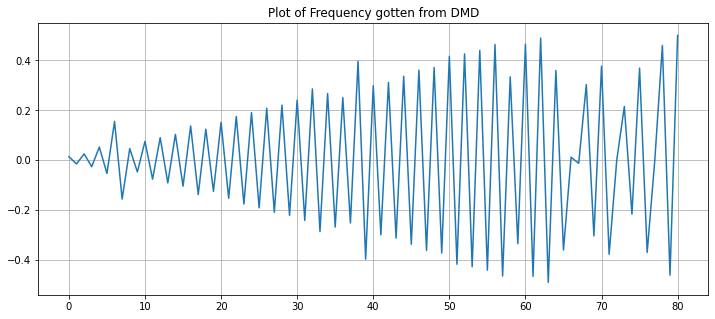

In [ ]:
        #plot of thr DMD frequency...
plt.figure(figsize=(12,5))
plt.plot(freq)
plt.grid()
plt.title("Plot of Frequency gotten from DMD")

In [ ]:
DMD_Spectrum = get_spectrum(h_modes)  
print("lenght of spectrum :" , len(DMD_Spectrum))
DMD_Spectrum

lenght of spectrum : 81


DeviceArray([0.9695029 , 0.9695029 , 0.9613226 , 0.9613226 , 0.9687604 ,
             0.9687604 , 0.9853799 , 0.9853799 , 0.94270575, 0.94270575,
             0.9559018 , 0.9559018 , 0.92576194, 0.92576194, 0.94294614,
             0.94294614, 0.94858086, 0.94858086, 0.90750355, 0.90750355,
             0.9342185 , 0.9342185 , 0.9318063 , 0.9318063 , 0.9225489 ,
             0.9225489 , 0.9306989 , 0.9306989 , 0.91660726, 0.91660726,
             0.9214591 , 0.9214591 , 0.9511256 , 0.9511256 , 0.9652707 ,
             0.9652707 , 0.8523273 , 0.8523273 , 0.9599098 , 0.9599098 ,
             0.9438092 , 0.9438092 , 0.99296147, 0.99296147, 0.962256  ,
             0.962256  , 0.9168602 , 0.9168602 , 0.9260323 , 0.9260323 ,
             0.92511034, 0.92511034, 0.9174649 , 0.9174649 , 0.9552286 ,
             0.9552286 , 0.9761827 , 0.9761827 , 0.7880604 , 0.7880604 ,
             0.8915665 , 0.8915665 , 0.83761233, 0.83761233, 0.5929173 ,
             0.5929173 , 0.45115432, 0.45115432, 0.

Text(0.5, 1.0, 'Plot of Spectrum gotten from DMD')

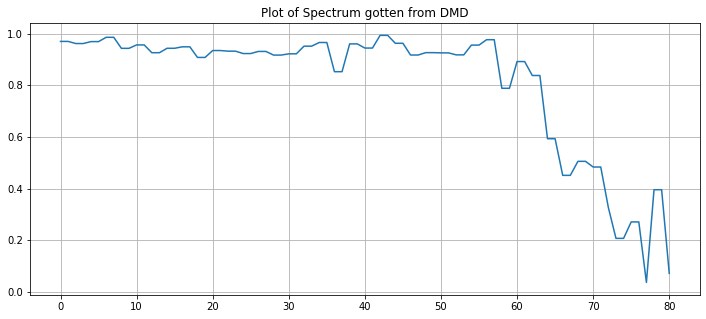

In [ ]:
        #plot of thr DMD spectrum...
plt.figure(figsize=(12,5))
plt.plot(DMD_Spectrum)
plt.grid()
plt.title("Plot of Spectrum gotten from DMD")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


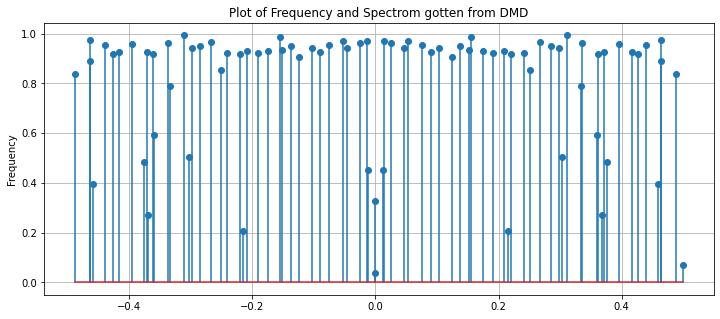

In [ ]:
        #plot of thr DMD frequency...
fig, ax = plt.subplots(figsize=(12,5))
ax.stem(freq,DMD_Spectrum,)
plt.grid()
plt.title("Plot of Frequency and Spectrom gotten from DMD")
plt.ylabel("Power Spectrum")
plt.ylabel("Frequency")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=81).
  """Entry point for launching an IPython kernel.


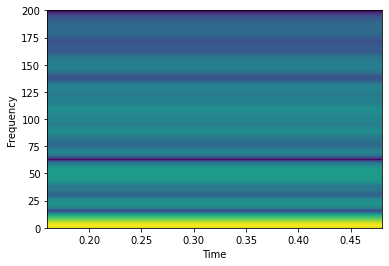

In [ ]:
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(DMD_Spectrum, Fs=400)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=81).
  """Entry point for launching an IPython kernel.


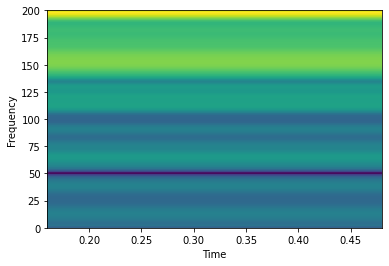

In [ ]:
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(freq, Fs=400)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

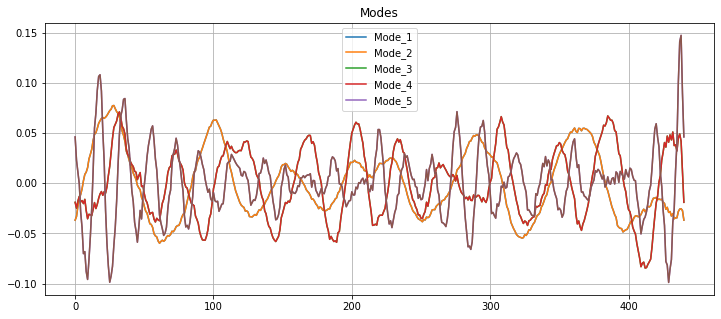

In [ ]:
#Visualization of mode...
legend = ["Mode_1","Mode_2","Mode_3","Mode_4","Mode_5"]
plt.figure(figsize=(12,5))
for m in h_ODMD.modes[:,:6].T:       
  plt.plot(m.real)        
  plt.title("Modes")
  plt.legend(legend)
plt.grid()
plt.show()

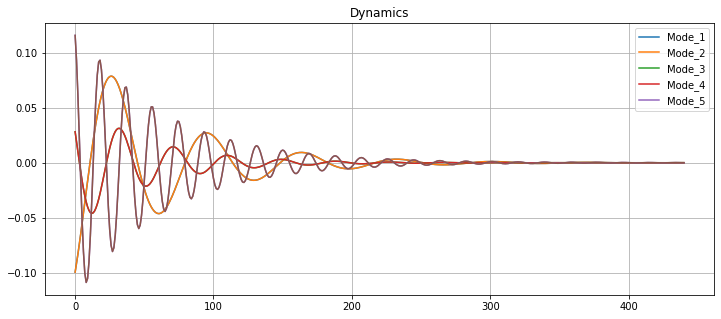

In [ ]:
legend = ["Mode_1","Mode_2","Mode_3","Mode_4","Mode_5"]
plt.figure(figsize=(12,5))
for d in h_ODMD.dynamics[:6,:]:  
    plt.plot(d.real)   
    plt.title("Dynamics")
    plt.legend(legend)
plt.grid()
plt.show()

###Applying Multi-Resolution DMD on the audio sample

- The first main concept to understand is that each DMD mode has a relative frequency and/ or decay rate determined by its eigenvalue $\lambda_{j}$

- These frequencies signifies the mode’s “speed” a fast mode oscillates/ grows/ decays rapidly, while a slow mode takes its time

-  A  mode’s speed should be proportional to $|ln(\lambda_{j})|$.

- So, a mode can be considered “slow” if it has a relatively low frequency or slow growth/ decay rate. This just means that the mode changes somewhat slowly as the system evolves in time.

- We could potentially decide that all eigenvalues within that circle correspond to slow modes while the rest correspond to fast modes.

- The multi-resolution DMD recursively extracts the “slow” modes at each time scale that it evaluates

In [ ]:
MR_mat = MAT_data.astype("float64",casting='same_kind' )      #make sure its in float64
MR_mat.dtype

dtype('float64')

In [ ]:
mr_DMD = MrDMD(svd_rank=0,exact= True,opt=True,max_cycles=2,max_level=5)      #computes the optimal rank and uses it for truncation;
mr_DMD.fit(MR_mat)      ##with mode cycles for each oscillation and 5 levels  

In [ ]:
print("Shape of Mode Matrix: ", mr_DMD.modes.shape)
print("Shape of Dynamic Matrix", mr_DMD.dynamics.shape)

Shape of Mode Matrix:  (441, 40)
Shape of Dynamic Matrix (40, 441)


[0.98145757+0.j         0.94902114+0.22697852j 0.94902114-0.22697852j
 0.98161775+0.j         0.94880611+0.2269544j  0.94880611-0.2269544j
 0.95322401+0.2485391j  0.95322401-0.2485391j  1.12591253+0.j
 0.96438236+0.19854685j 0.96438236-0.19854685j 0.85962992+0.37946538j
 0.85962992-0.37946538j 0.95331176+0.24867435j 0.95331176-0.24867435j
 1.12526388+0.j         0.96414781+0.19841289j 0.96414781-0.19841289j
 0.85935064+0.37877494j 0.85935064-0.37877494j 0.81405922+0.j
 1.00997976+0.j         0.90937759+0.28056769j 0.90937759-0.28056769j
 1.02693976+0.j         0.9363336 +0.j         0.81394456+0.j
 1.00990481+0.j         0.90976102+0.28205611j 0.90976102-0.28205611j
 1.02747172+0.j         0.93710004+0.j         0.99871486+0.j
 0.97172492+0.j         1.01017965+0.j         0.89925424+0.j
 0.99822038+0.j         0.97167309+0.j         1.01040821+0.j
 0.89754324+0.j        ]


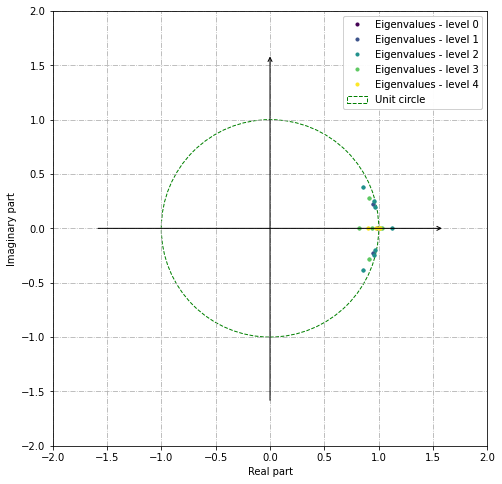

In [ ]:
##Eigen values at differet levels...
MR_eigs = mr_DMD.eigs
print(MR_eigs)


mr_DMD.plot_eigs(show_axes= True,show_unit_circle=True)

Text(0.5, 1.0, 'Plot of MR_DMDFrequency for 20ms of Bird_chirping audio data')

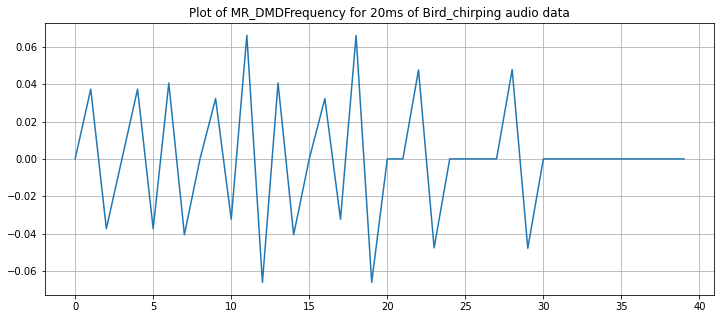

In [ ]:
###frequency from eigen values
mr_freq = get_freq(MR_eigs)
plt.figure(figsize=(12,5))
plt.plot(mr_freq)
plt.grid()
plt.title("Plot of MR_DMDFrequency for 20ms of Bird_chirping audio data")

In [ ]:
mr_DMD_Spectrum = get_spectrum(mr_DMD.modes)
mr_DMD_Spectrum

DeviceArray([0.9997431 , 1.0003242 , 1.0003242 , 1.0000436 , 0.99994636,
             0.99994636, 0.9756367 , 0.9756367 , 1.3711712 , 1.0001612 ,
             1.0001612 , 0.98945826, 0.98945826, 0.9758724 , 0.9758724 ,
             1.3700424 , 0.9998441 , 0.9998441 , 0.98828846, 0.98828846,
             0.6743258 , 1.0213046 , 0.91475475, 0.91475475, 1.0574594 ,
             0.893689  , 0.6740841 , 1.0211524 , 0.91604847, 0.91604847,
             1.0585816 , 0.89511955, 1.0011603 , 0.9451832 , 1.0245298 ,
             0.82736224, 1.0001919 , 0.9450762 , 1.0249712 , 0.8243432 ],            dtype=float32)

Text(0.5, 1.0, 'Plot of Spectrum gotten from DMD')

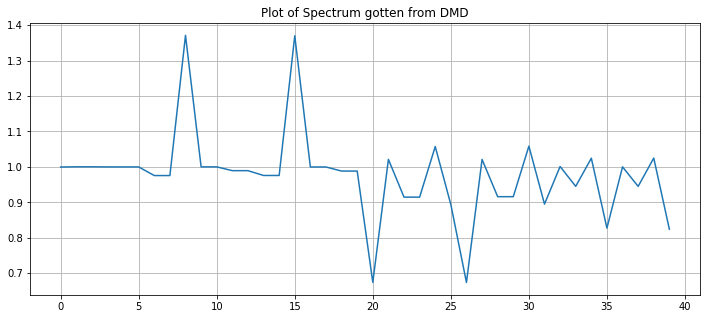

In [ ]:
        #plot of thr DMD spectrum...
plt.figure(figsize=(12,5))
plt.plot(mr_DMD_Spectrum)
plt.grid()
plt.title("Plot of Spectrum gotten from DMD")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


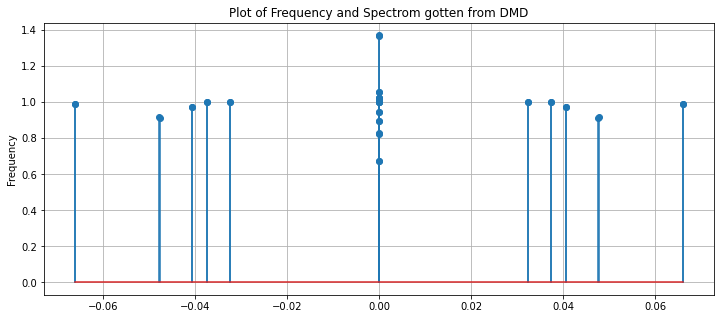

In [ ]:
        #plot of thr DMD frequency...
fig, ax = plt.subplots(figsize=(12,5))
ax.stem(mr_freq,mr_DMD_Spectrum,)
plt.grid()
plt.title("Plot of Frequency and Spectrom gotten from DMD")
plt.ylabel("Power Spectrum")
plt.ylabel("Frequency")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=40).
  """Entry point for launching an IPython kernel.


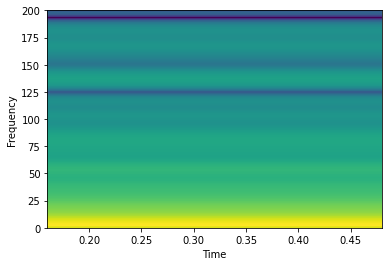

In [ ]:
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(mr_DMD_Spectrum, Fs=400)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=40).
  """Entry point for launching an IPython kernel.


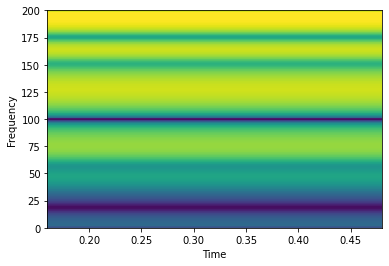

In [ ]:
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(mr_freq, Fs=400)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

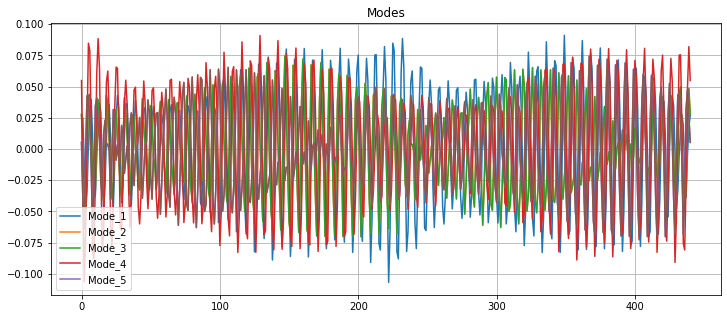

In [ ]:
#Visualization of mode...
legend = ["Mode_1","Mode_2","Mode_3","Mode_4","Mode_5"]
plt.figure(figsize=(12,5))
for m in mr_DMD.modes[:,:6].T:       
  plt.plot(m.real)        
  plt.title("Modes")
  plt.legend(legend)
plt.grid()
plt.show()

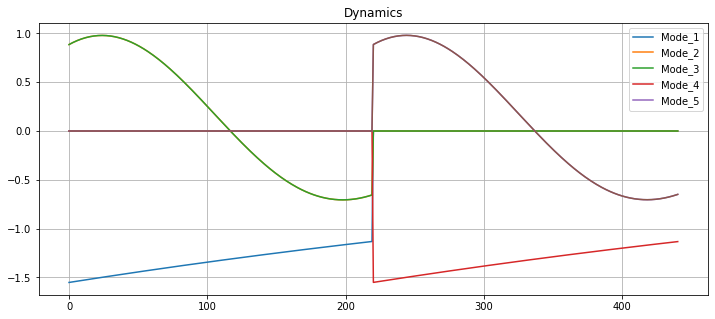

In [ ]:
legend = ["Mode_1","Mode_2","Mode_3","Mode_4","Mode_5"]
plt.figure(figsize=(12,5))
for d in mr_DMD.dynamics[:6,:]:  
    plt.plot(d.real)   
    plt.title("Dynamics")
    plt.legend(legend)
plt.grid()
plt.show()

#PART 2a: Computing Mel Frequency Ceptral Coefficient from DMD Spectrum

- After succesfully extracting the audio signal frequencies and Spectrum;

- Next step is to compute MFCC from the DMD power spectrum

###MFCC

- MFCC is good at identifing the linguistic components of an audio signal

- Because it accurately determines the shape of the vocal tract by which the signal is produced.

- and this gives us the representation of the phoneme being produced

- The shape of the vocal tract manifests itself in the envelope of the short time power spectrum,

- MFCCs accurately represent this envelope.

- I followed the following steps in computing MFCC from DMD spectrum

###Step 1: Getting Audio Signal into frames

- Returning a Matrix: 

- with rows = num of frames

-  and columns = num of samples in each frame

In [ ]:
import jax.numpy as jnp
import numpy as np

In [ ]:
def preemphasis(signal, coeff=0.95):
    return np.append(signal[0], signal[1:] - coeff * signal[:-1])

def rolling_window(a, window, step=1):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)[::step] 

def round_half_up(y):
    return int(dc.Decimal(y).quantize(dc.Decimal('1'), rounding=dc.ROUND_HALF_UP))

def get_framed_signal(x,frame_len,frame_step,coeff=0.95,winfunc=lambda x: np.ones((x,))):
  x = preemphasis(x,coeff)
  len_x = len(x)                                 #length of audio signal
  frame_len =  int(round_half_up(frame_len))    #num of samples in each frame(441 sample fo rbird)
  frame_step = int(round_half_up(frame_step))   #num of samples in each frame(220 sampele for bird)

  numframes = 1 + int(math.ceil((1.0 * len_x - frame_len) / frame_step))   #num of frames
  padlen = int((numframes - 1) * frame_step + frame_len)
  zeros = np.zeros((padlen - len_x,))
  padsignal = np.concatenate((x, zeros))

  win = winfunc(frame_len)
  frames = rolling_window(padsignal,window=frame_len, step=frame_step)
  framed_signal = frames * win
  return framed_signal

###Step 2: Computing DMD Spectrum from the framed signal

- Computing power spectral of each frame with HODMD 

- this returns a PowerSpectral Matrix in which each of its row correspond to the spectrum of each frame

In [ ]:
# def get_DMD_Mat(framed_sig,N):                         #get suitable matrix from audio signal
#   Matrix_list = []
#   for frame in framed_sig:
#     hankel_mat = hankel(frame,frame)
#     slice_MAT = hankel_mat[:,:N]                       #get the 1st N-colums 
#     slice_MAT_step = hankel_mat[:,1:N+1]               #time shifted mat of slice
#     slice_MAT_Pinv = np.linalg.pinv(slice_MAT)
#     DMD_MAT = np.matmul(slice_MAT_step,slice_MAT_Pinv)
#     Matrix_list.append(DMD_MAT)                        #len(list) == number of frames 
#   return Matrix_list                                   #return a list with MATrix for each frame  

In [ ]:
import numpy as np                                                                  #computing spectrum with HODMD
def computeDMDSpec(framed_signal,mode_per_frame=5,exact=True,opt=True,d=30):   #mode_num == num of required mode
  Spec_list = [] 
  h_ODMD = HODMD(svd_rank=mode_per_frame,exact=exact,opt=opt,d=d)
  for frame in framed_signal:
    h_ODMD.fit(frame)
    Mode_Mags =  np.sum(np.abs(h_ODMD.modes.T)**2,axis=-1)**(1./2)      ##magnitude of each mode
    DMD_Spectrum = (Mode_Mags)**2
    Spec_list.append(DMD_Spectrum)
  PowSpec = np.stack(Spec_list,axis=0)                                        #each row correspond to the power spectrum of each frame
  return PowSpec                                                        #return matrix of spectrogram 

###Step 3: Energy Evaluation from DMDSpectral 

- This is done by applying a series of mel filterbanks to the power spectra, to get 2 set of parameters;

- The first is a matrix containing the Mel-filterbank energy  of size (num_frames by num_modes),

- The second returns  the energy values of each frame



In [ ]:
def get_filterBanks(sample_rate,mode_per_frame,num_filters=26,
                    low_freq=300,high_freq = 8000):
    n_ = (mode_per_frame-1)*2
    low_mel =  2595 * np.log10(1+low_freq/700.)               #converting of the freqncies to mel values
    high_mel = 2595 * np.log10(1+high_freq/700.)

    mel_points = np.linspace(low_mel,high_mel,num_filters+2)   #getting the melpoints
    frq_points = 700*(10**(mel_points/2595.0)-1)    
    FFT_bin = np.floor((n_+1)*frq_points/sample_rate)  

    filter_bank = np.zeros([num_filters,n_//2+1])
    for j in range(0,num_filters):
        for i in range(int(FFT_bin[j]), int(FFT_bin[j+1])):
            filter_bank[j,i] = (i - FFT_bin[j]) / (FFT_bin[j+1]-FFT_bin[j])
        for i in range(int(FFT_bin[j+1]), int(FFT_bin[j+2])):
            filter_bank[j,i] = (FFT_bin[j+2]-i) / (FFT_bin[j+2]-FFT_bin[j+1])
    return filter_bank  


In [ ]:
def filterBanksEnergy(framed_signal,sample_rate,mode_per_frame,win_len=0.02,
                win_step=0.01,N=64,winfunc=lambda x:np.ones((x,))):
  
  #mat_list = get_DMD_Mat(framed_signal,N)
  DMD_PowMAT = computeDMDSpec(framed_signal,mode_per_frame)                           ##matrix of power matrix spectrum
                                                                  ##Total Energy in each , 
  Frame_energy = np.sum(DMD_PowMAT,axis=1)                        ##size of energy == total num_of_frame(single array)
  Frame_energy = np.where(Frame_energy == 0,np.finfo(float).eps,Frame_energy) 

  filter_banks = get_filterBanks(sample_rate,mode_per_frame)
  filterB_energy = np.dot(DMD_PowMAT,filter_banks.T)                  #compute the filterbank energies
  filterB_energy = np.where(filterB_energy == 0,np.finfo(float).eps,filterB_energy)
                                                                      #compute the log of the filter bank energy     
  #filterB_energy_log = np.log(filterB_energy)
  return filterB_energy, Frame_energy

###Step 4: MFCC computation form filter energies

- This is done by taking logarithm of mel-filterbankenergy, which allows to use of the cepstral mean subtraction, which is a channel normalisation technique.

- The logarithm of the filterBank energy gives the **Mel Frequency Spectral Coefficient[MFSC]**

- then Computing the Discrete Cosine Transform(DCT) of the log filterBank energy(MFSC) to get the Mel fequency Ceptral Coefficient

 

In [ ]:
def lift_MFCC(cepstra, Lift_coeff=22):
  nframes,ncoeff = np.shape(cepstra)
  n = np.arange(ncoeff)
  lift = 1 + (Lift_coeff/2.)*np.sin(np.pi*n/Lift_coeff)
  return lift*cepstra

In [ ]:
def get_MFCC(filterB_energy,Frame_energy):
    MFSC = np.log(filterB_energy)              #log of the filter Bank energy == Mel Freq septral coefficient
    MFCC = dct(MFSC, type=2, axis=1, 
            norm='ortho')[:,:num_cep]           #These 13 are the MFCC
    MFCC = lift_MFCC(MFCC)                      #lifting high frequencies by a fact of 22
    MFCC[:,0] = np.log(Frame_energy)           #replace first cepstral coefficient with log of frame energy
    return MFCC

###Testing on "Bird_chirping"

In [ ]:
sample_rate = 22050
win_len = 0.02                       #20 milliseconds window length
win_step = 0.01                      #10 milliseconds window step  
frame_len = win_len*sample_rate      #num of samples in a frame
frame_step = win_step*sample_rate    #num of samples in steps
num_cep = 40                         #num of septral coefficients   
mode_num = 75
N = 64

In [ ]:
framed_signal = get_framed_signal(data_bird,frame_len,frame_step)
framed_signal

array([[-2.94192377e-02, -1.08938888e-01,  4.66631427e-02, ...,
        -1.69192106e-01, -1.34666026e-01,  1.47894025e-04],
       [-4.29315120e-03, -2.77674571e-03,  9.16822255e-02, ...,
        -1.78059012e-01, -9.27387774e-02,  1.34201303e-01],
       [ 1.55901268e-01,  1.26046732e-01, -1.01149976e-01, ...,
         1.29329488e-01,  4.88047540e-01,  1.81229413e-01],
       ...,
       [ 1.17491800e-02,  1.86667964e-02, -1.20704360e-02, ...,
         3.26331146e-03,  3.62501256e-02,  1.93186887e-02],
       [-4.89075705e-02, -2.06508618e-02,  2.21017208e-02, ...,
        -1.10284239e-03,  7.14618899e-03,  2.05334928e-02],
       [ 1.27991699e-02,  1.92707889e-02, -3.09259258e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [ ]:
framed_signal.shape  ##rows == num of frames

(498, 441)

In [ ]:
#framed_sig[0]  ##the rows represent the frames
framed_sig = framed_signal[:5,:]   ##get 5 frames for testing
framed_sig.shape

(5, 441)

In [ ]:
filterB_energy, Frame_energy  = filterBanksEnergy(framed_sig,sample_rate,mode_num) 

In [ ]:
Frame_energy.shape

(5,)

In [ ]:
MFCC = get_MFCC(filterB_energy,Frame_energy)
MFCCS_scaled = np.mean(MFCC,axis=1)
MFCCS_scaled

array([17.48273985, 17.6009978 , 17.54049107, 17.60408718, 17.63351753])

In [ ]:
MFCCS_scaled.shape

(5,)

#PART 2b: Simplified Approach of Computing MFCC from DMD Spectrum 

- The librosa function for audioprocessing already makes it easy to extract the MFCC from a pre-computed Power Spectrum

- Get the DMD Power Spectrum

- Compute the Mel-Spectrogram from the DMD Power spectrum above using *librosa.feature.melspectrogram*

- compute MFCC from the melspectrogram above using *librosa.feature.mfcc*

###Testing on single audio file

In [ ]:
def mfcc_extraction(audio_file,win_len,win_step,mode_per_frame,n_mels=40,n_mfcc=40):
    audio_data,sample_rate = librosa.load(audio_file,res_type='kaiser_fast')
    frame_len = win_len*sample_rate                    #num of samples in a frame
    frame_step = win_step*sample_rate                  #num of samples in steps
                                       #default "top_db = 60db" : i.e everything below 20db is consider as silence
    non_silent_interval = librosa.effects.split(audio_data,frame_length=int(frame_len),hop_length=int(frame_step))  
    non_silent_signal = audio_data[non_silent_interval[0][0]:non_silent_interval[0][1]]
    framed_signal = get_framed_signal(non_silent_signal,frame_len,frame_step)    

    ################################################################################################                                                      
    framed_sig = framed_signal[1:-1,:]  #remove 1st and last frames incase of any pendinf zero regions
    ################################################################################################  
       
    DMD_PowMAT = computeDMDSpec(framed_sig,mode_per_frame)  #get POwer Spectrum via DMD
    MelSpec = librosa.feature.melspectrogram(S=DMD_PowMAT, sr=sample_rate, n_mels=n_mels)
    MFCC = librosa.feature.mfcc(S=librosa.power_to_db(MelSpec), n_mfcc=n_mfcc)
    MFCCS_scaled = np.mean(MFCC,axis=1)
    return MFCCS_scaled

- Testing on sound without silent parts:

sampling rate: 22050
wav shape: (110250,)


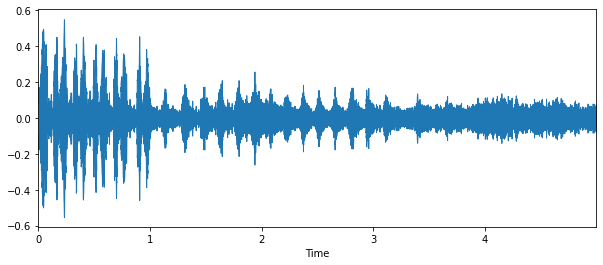

In [ ]:
#print("Bird_chirping...")
dir_2 =  "/content/datasets/esc/esc50/ESC-50-master/audio/1-100038-A-14.wav"
plt.figure(figsize=(10,4))
data_bird,sample_rate = librosa.load(dir_2)
print('sampling rate:', sample_rate)
print('wav shape:', data_bird.shape)
_ = librosa.display.waveplot(data_bird,sr=sample_rate)
ipd.Audio(dir_2)

In [ ]:

win_len = 0.02                     #20 milliseconds window length
win_step = 0.01                    #10 milliseconds window step  
mode_per_frame = 5
frame_len = win_len*sample_rate    #num of samples in a frame
frame_step = win_step*sample_rate 
print("frame_lenght :", frame_len)
print("frame_step :",frame_step)

frame_lenght : 441.0
frame_step : 220.5


In [ ]:
MFCCS_scaled = mfcc_extraction(dir_2,win_len,win_step,mode_per_frame,n_mels=40,n_mfcc=40)
MFCCS_scaled

array([-1.80476290e+02, -8.28566109e-01, -1.63103458e+00, -7.98895179e-02,
       -4.09251509e-01,  4.01061422e-01, -3.40205273e-02, -1.77125707e-02,
       -1.04810329e-01, -5.49485327e-01, -2.67475444e-01, -8.56906716e-02,
        1.09617095e-01,  1.47563287e+00,  1.63327115e+00,  9.69374657e-01,
        9.03651265e-01, -5.80862214e-01, -1.19011390e+00, -1.34977344e+00,
       -5.26169606e-02,  5.81402662e-01,  8.72556084e-01,  4.65665365e-02,
        1.43848389e-01, -3.96766417e-01,  7.16585108e-01,  8.34313912e-01,
        2.76568818e-01,  3.51429349e-01,  1.40500392e-02,  2.12566968e-01,
       -2.67375236e-01, -1.03982463e-01, -3.47279880e-01, -2.30166543e-01,
       -2.84021201e-01, -7.09515241e-02, -1.85917955e-01,  3.07266090e-02])

- Testing on sound with silent part:

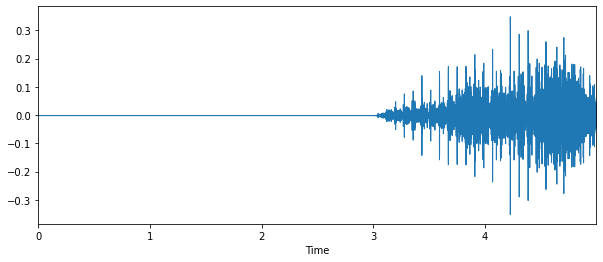

In [ ]:
#print("Bird_chirping...")
dir_2 =  "/content/datasets/esc/esc50/ESC-50-master/audio/4-161579-A-40.wav"
plt.figure(figsize=(10,4))
data_bird,sample_rate = librosa.load(dir_2)
_ = librosa.display.waveplot(data_bird,sr=sample_rate)

In [ ]:
##test nn sound with zero-parts..
mfcc_extraction(dir_2,win_len,win_step,mode_per_frame,n_mels=40,n_mfcc=40)

array([-1.74541159e+02, -2.84850722e-01,  4.18736726e-01, -2.39203295e-01,
       -2.68743861e-01, -2.16774862e-01,  2.41117100e-01,  1.34484525e-01,
       -3.14540454e-01, -5.91262035e-01, -4.02094465e-02,  8.33422111e-01,
        3.55189506e-01,  2.64604801e-01,  6.07340200e-02,  2.90736582e-01,
        2.15483685e-01,  2.00691583e-01, -2.76347557e-01, -2.69678868e-01,
       -1.05419956e-01, -1.14104507e-01,  6.11000285e-02, -1.76898112e-01,
       -2.31488135e-01, -2.00342547e-01,  2.02579641e-02,  2.06772293e-01,
        3.66080910e-01,  3.47667815e-01,  1.85419663e-02, -4.51008498e-02,
       -2.86713074e-01, -1.02172939e-01, -4.24893217e-02, -3.45008595e-01,
       -2.61516090e-01, -4.52391016e-01, -4.36445783e-01,  1.24059117e-01])

###Testing on sets of audio files for classification purpose

In [ ]:
df_esc50 = pd.read_csv('/content/datasets/esc/esc50/ESC-50-master/meta/esc50.csv')

In [ ]:
#df_esc50[fold].dtype 
#df_esc50[df_esc50['fold'] == 5]  
                                                       ##extract 200 samples from each fold for testing purpose 
#sample_df = df_esc50.groupby('fold').head(200).reset_index(drop=True)
#sample_df

In [ ]:
df_esc50['category'].unique()

array(['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm',
       'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks',
       'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train',
       'sheep', 'water_drops', 'church_bells', 'clock_alarm',
       'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow',
       'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter',
       'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine',
       'breathing', 'crying_baby', 'hand_saw', 'coughing',
       'glass_breaking', 'snoring', 'toilet_flush', 'pig',
       'washing_machine', 'clock_tick', 'sneezing', 'rooster',
       'sea_waves', 'siren', 'cat', 'door_wood_creaks', 'crickets'],
      dtype=object)

In [ ]:
sample_df = df_esc50[(df_esc50["category"] == 'train')|(df_esc50["category"] == 'washing_machine')|
                 (df_esc50["category"] == 'brushing_teeth')|(df_esc50["category"] == 'chirping_birds')|
                 (df_esc50["category"] == 'vacuum_cleaner')| (df_esc50["category"] == 'clock_alarm')|
                 (df_esc50["category"] == 'clapping')|(df_esc50["category"] == 'helicopter')|
                 (df_esc50["category"] == 'hand_saw')|(df_esc50["category"] == 'siren') |
                 (df_esc50["category"] == 'airplane')| (df_esc50["category"] == 'laughing')|
                 (df_esc50["category"] == 'thunderstorm')|(df_esc50["category"] == 'church_bells')|
                 (df_esc50["category"] == 'crying_baby')|(df_esc50["category"] == 'fireworks')|
                 (df_esc50["category"] == 'rain')|(df_esc50["category"] == 'keyboard_typing')|
                 (df_esc50["category"] == 'engine')|(df_esc50["category"] == 'car_horn')|
                 (df_esc50["category"] == 'crickets')|(df_esc50["category"] == 'mouse_click')|
                 (df_esc50["category"] == 'frog')|(df_esc50["category"] == 'cow')|
                 (df_esc50["category"] == 'pig') ]


# sample_df = df_esc50[(df_esc50["category"] == 'dog')|(df_esc50["category"] == 'hen')|
#                  (df_esc50["category"] == 'door_wood_knock')|(df_esc50["category"] == 'chirping_birds')|
#                  (df_esc50["category"] == 'can_opening')| (df_esc50["category"] == 'breathing')|
#                  (df_esc50["category"] == 'crow')|(df_esc50["category"] == 'coughing')|
#                  (df_esc50["category"] == 'chainsaw')|(df_esc50["category"] == 'glass_breaking') |
#                  (df_esc50["category"] == 'pouring_water')| (df_esc50["category"] == 'snoring')|
#                  (df_esc50["category"] == 'sheep')|(df_esc50["category"] == 'toilet_flush')|
#                  (df_esc50["category"] == 'water_drops')|(df_esc50["category"] == 'clock_tick')|
#                  (df_esc50["category"] == 'wind')|(df_esc50["category"] == 'sneezing')|
#                  (df_esc50["category"] == 'footsteps')|(df_esc50["category"] == 'rooster')|
#                  (df_esc50["category"] == 'crackling_fire')|(df_esc50["category"] == 'sea_waves')|
#                  (df_esc50["category"] == 'drinking_sipping')|(df_esc50["category"] == 'door_wood_creaks')|
#                  (df_esc50["category"] == 'insects') ]
# sample_df                 
sample_df

,filename,fold,target,category,esc10,src_file,take
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
5,1-101296-B-19.wav,1,19,thunderstorm,False,101296,B
...,...,...,...,...,...,...,...
1982,5-260875-A-35.wav,5,35,washing_machine,False,260875,A
1988,5-262957-A-22.wav,5,22,clapping,False,262957,A
1992,5-263775-A-26.wav,5,26,laughing,False,263775,A
1993,5-263775-B-26.wav,5,26,laughing,False,263775,B


In [ ]:
sample_df['category'].unique()

array(['chirping_birds', 'vacuum_cleaner', 'thunderstorm', 'clapping',
       'fireworks', 'airplane', 'mouse_click', 'train', 'church_bells',
       'clock_alarm', 'keyboard_typing', 'frog', 'cow', 'brushing_teeth',
       'car_horn', 'helicopter', 'rain', 'laughing', 'engine',
       'crying_baby', 'hand_saw', 'pig', 'washing_machine', 'siren',
       'crickets'], dtype=object)

In [ ]:
test_sample = sample_df[790:1000]
test_sample

,filename,fold,target,category,esc10,src_file,take
1590,4-67358-A-42.wav,4,42,siren,False,67358,A
1591,4-80761-A-42.wav,4,42,siren,False,80761,A
1592,4-90014-A-42.wav,4,42,siren,False,90014,A
1593,4-90014-B-42.wav,4,42,siren,False,90014,B
1594,4-99193-A-4.wav,4,4,frog,False,99193,A
...,...,...,...,...,...,...,...
1982,5-260875-A-35.wav,5,35,washing_machine,False,260875,A
1988,5-262957-A-22.wav,5,22,clapping,False,262957,A
1992,5-263775-A-26.wav,5,26,laughing,False,263775,A
1993,5-263775-B-26.wav,5,26,laughing,False,263775,B


In [ ]:
DATA_PATH = "/content/datasets/esc/esc50/ESC-50-master/audio/"
#features = []

In [ ]:
#iterate through each sound file and extract the features...
import warnings
warnings.filterwarnings('ignore')
for index, row in test_sample.iterrows():
  audio_file = os.path.join(os.path.abspath(DATA_PATH),str(row["filename"]))
  class_label = row['category']
  audio_data  = mfcc_extraction(audio_file,win_len,win_step,mode_per_frame,n_mels=40,n_mfcc=40)
  features.append([audio_data,class_label])
  print(index)

1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1623
1624
1625
1626
1627
1630
1631
1632
1633
1634
1635
1636
1637
1638
1644
1652
1653
1654
1655
1656
1658
1661
1662
1663
1664
1665
1666
1667
1668
1669
1671
1672
1673
1674
1675
1677
1679
1684
1685
1688
1689
1691
1692
1693
1694
1697
1698
1700
1701
1705
1706
1707
1708
1709
1715
1716
1717
1718
1719
1722
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1740
1741
1750
1751
1758
1759
1762
1764
1765
1767
1768
1771
1774
1775
1788
1789
1790
1791
1793
1795
1796
1797
1798
1816
1817
1818
1819
1820
1821
1825
1826
1827
1828
1836
1837
1838
1841
1842
1843
1844
1851
1852
1856
1857
1860
1863
1864
1865
1866
1867
1868
1869
1870
1872
1873
1875
1881
1884
1890
1891
1897
1900
1901
1903
1905
1906
1907
1909
1910
1911
1913
1914
1917
1918
1919
1920
1921
1923
1924
1925
1926
1933
1934
1936
1941
1944
1945
1950
1951
1952
1953
1955
1956
1957
1958
1959
1960
1961
1962


In [ ]:
#features....
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

In [ ]:
featuresdf.shape

(996, 2)

In [ ]:
featuresdf.to_csv('features_df.csv')

In [ ]:
featuresdf

,feature,class_label
0,"[-180.47629020004106, -0.8285661088636918, -1....",chirping_birds
1,"[-178.89232211785247, 1.416012633462771, 1.717...",vacuum_cleaner
2,"[-180.01224588550963, -0.27274708724759117, -0...",vacuum_cleaner
3,"[-170.509405677653, 1.2700561302058595, -2.678...",thunderstorm
4,"[-173.14207661199742, -7.062889468704606, 0.51...",thunderstorm
...,...,...
991,"[-166.0118890289461, 0.807309499184225, -0.408...",washing_machine
992,"[-175.6784803068105, -1.9245156091716702, -0.6...",clapping
993,"[-219.88601399956997, 0.4691727082599172, 0.57...",laughing
994,"[-178.11006088533117, -0.7173625107461794, 3.0...",laughing


#Part 3: Sound Classification Experiement

In [ ]:
pip install git+https://github.com/deepmind/dm-haiku

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-kcx4dy7p
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-kcx4dy7p
  Created wheel for dm-haiku: filename=dm_haiku-0.0.1-cp36-none-any.whl size=271783 sha256=5e50d408779611638a32c0b2269fb033e1f5aec410b79da6772cf150a1cbf89c
  Stored in directory: /tmp/pip-ephem-wheel-cache-lqz13q2g/wheels/97/0f/e9/17f34e377f8d4060fa88a7e82bee5d8afbf7972384768a5499
Successfully built dm-haiku


In [ ]:
%matplotlib inline
%config InlinrBackend.figure_format = 'retina'

In [ ]:
import jax
import time
import haiku as hk
import jax.numpy as jnp
import numpy as onp
import pandas as pd
from jax import random
import seaborn as sns
from IPython import  display
from jax import grad,jit,vmap,value_and_grad
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
          #importing optimizers from JAX
from jax.scipy.special import logsumexp
from jax.experimental import optimizers

In [ ]:
           #Generate key which is used to generate random numbers..
           #pseudorandom number generator (PRNG)
key = random.PRNGKey(1)

In [ ]:
                          #Converting features and corresponding 
                          #classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

                         #Encoding the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [ ]:
print("X_shape : ", X.shape)
print("y_shape : ",yy.shape)

X_shape :  (996, 40)
y_shape :  (996, 25)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)
print("X_train shape : ", x_train.shape)
print("y_train shape : ", y_train.shape)
print("X_test shape  : ", x_test.shape)
print("y_test shape  : ", y_test.shape)

X_train shape :  (796, 40)
y_train shape :  (796, 25)
X_test shape  :  (200, 40)
y_test shape  :  (200, 25)


In [ ]:
print("List of Classes", featuresdf.class_label.unique())
print("Number of Classes", featuresdf.class_label.nunique())

List of Classes ['chirping_birds' 'vacuum_cleaner' 'thunderstorm' 'clapping' 'fireworks'
 'airplane' 'mouse_click' 'train' 'church_bells' 'clock_alarm'
 'keyboard_typing' 'frog' 'cow' 'brushing_teeth' 'car_horn' 'helicopter'
 'rain' 'laughing' 'engine' 'crying_baby' 'hand_saw' 'pig'
 'washing_machine' 'siren' 'crickets']
Number of Classes 25


###Model attempt with MLP in JAX

- The following functions are needed to train a MultiLayer perceptron

- A function that **initialzes the weights of the Neural Network**, and returns a list of layer-specific parameters

- A function that performs **forward pass** through the network

- A function that performs **cross-entropy loss** of the predictions

- A function that **evaluates the accuracy** of the prediction

- A function that **updates the parameters** using some form of gradient descent

- The first layer will receive the input shape. As each sample contains 40 MFCCs (or columns) 

- I then have a shape of (1x40) this means we will start with an input shape of 40.

- The first two layers will have 512 nodes. 

In [ ]:
                                              #defining the ReLu activation function - "Rectified Linear Unit"
def ReLu(x):
  return jnp.maximum(0,x)
                                                #speeding this up with jit
jit_ReLu = jit(ReLu)    

def relu_layer(weight,bias,x):                   #ReLu(x) == np.max(0,x)
  Relu_output = ReLu(jnp.dot(weight,x) + bias)   #ReLu(y = XW + b)
  return Relu_output 

def relu_layer_batched(weight,bias,x):
  Batched_Relu = ReLu(jnp.dot(x,weight.T) + bias)   #ReLu(y = XW.T + b)
  return Batched_Relu

                                                    #creating a one-hot encoding of x of size k...
def one_hot(x,k,dtype=jnp.float32):
  return jnp.array(x[:,None] == jnp.arange(k),dtype)  

def relu_layer_vmap(weight,bias,x):                 #simply put the ReLu_layer in "vmap" and then "jit" it 
  vmap_relu = jit(vmap(relu_layer,in_axes=(None,0),out_axes=0))  
  return vmap_relu  

In [ ]:
def initialize_mlp(sizes,key):                 #func for initilization of parameters 
  all_ex_last  = sizes[:-1] 
  all_ex_first = sizes[1:]
  keys = random.split(key,len(sizes))
  def initilize_layer(m,n,key,scale=1e-2):
    w_key,b_key = random.split(key)
    scale_1 = scale*random.normal(w_key,(n,m))
    scale_2 = scale*random.normal(b_key,(n,))
    return scale_1,scale_2
  return [initilize_layer(m,n,k) for m,n,k in zip(all_ex_last,all_ex_first,keys)]


In [ ]:
layer_size = [40, 512, 512 , 25]            #input =[40] || then 2-hidden_layers each of size [512] || num_clases = 50
params= initialize_mlp(layer_size,key)      

In [ ]:
def forward_pass(params,in_layer):
  activations = in_layer                          #each layer's output... == another layer's input
  for w,b in params[:-1]:                         #looping over the ReLu hidden layers
    activations = relu_layer(w,b,activations)

  final_w,final_b = params[-1]
  logits = jnp.dot(final_w,activations) + final_b   #logits = layer_output[-1]
  return logits - logsumexp(logits)                 #logsumexp() from jax

                                                    #batching the forward_pass
batch_forward = vmap(forward_pass, 
                     in_axes=(None, 0), 
                     out_axes=0)  

In [ ]:
@jax.jit                                    #computing a multiclass cross-entropy loss
def loss(params,in_layer,targets):
  preds = batch_forward(params,in_layer)    #batch_forward is vectorized version of the forward_pass,   
  loss = -jnp.sum(preds*targets)            #and it returns teh prediction
  return loss

@jax.jit                                         #computing accuracy....
def accuracy(params,data,targets):
  target_class = jnp.argmax(targets,axis=1)      #targets== already 0ne -hot endcoded
  pred_class = jnp.argmax(batch_forward(params,data),axis=1)  #in_layer == data_sample
  acc = jnp.mean(pred_class == target_class)
  return acc
  
@jax.jit                                          #function that computes the gradient 
def update(params,x,y,opt_state):                 #for a batch and update the parameters
  value, grad = value_and_grad(loss)(params,x,y)  #value_and_grad() computes a function and its gradient
  opt_state = opt_update(0,grad,opt_state)
  return get_params(opt_state),opt_state,loss

step_size = 1e-3
opt_init,opt_update,get_params = optimizers.adam(step_size)  #Adam optimizer from JAX
opt_state = opt_init(params)
num_epochs = 30
num_classes = 13 

In [ ]:
 def training_loop(num_epochs, opt_state):
    log_acc_train, log_acc_test, train_loss = [], [], []                                    
    params = get_params(opt_state)                 #Get the initial set of parameters
    train_acc = accuracy(params,x_train,y_train)   #Get initial accuracy after random init
    test_acc = accuracy(params,x_test,y_test)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)

                                                    #Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        params, opt_state, loss = update(params,
                                         x_train,
                                         y_train,
                                         opt_state)
        train_loss.append(loss)
        epoch_time = time.time() - start_time
        train_acc = accuracy(params,x_train,y_train)
        test_acc = accuracy(params,x_test,y_test)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        print("Epoch {} | T: {:0.2f} | Train Acc: {:0.3f} | Test Acc: {:0.3f}".format(epoch+1, epoch_time,
                                                                    train_acc, test_acc))

        #display.clear_output(wait=True)  
    return train_loss, log_acc_train, log_acc_test

In [ ]:
train_loss, train_log, test_log = training_loop(num_epochs,opt_state)

Epoch 1 | T: 1.65 | Train Acc: 0.040 | Test Acc: 0.040
Epoch 2 | T: 0.00 | Train Acc: 0.055 | Test Acc: 0.020
Epoch 3 | T: 0.00 | Train Acc: 0.053 | Test Acc: 0.040
Epoch 4 | T: 0.00 | Train Acc: 0.055 | Test Acc: 0.020
Epoch 5 | T: 0.00 | Train Acc: 0.055 | Test Acc: 0.020
Epoch 6 | T: 0.00 | Train Acc: 0.055 | Test Acc: 0.020
Epoch 7 | T: 0.00 | Train Acc: 0.057 | Test Acc: 0.020
Epoch 8 | T: 0.00 | Train Acc: 0.067 | Test Acc: 0.030
Epoch 9 | T: 0.00 | Train Acc: 0.057 | Test Acc: 0.015
Epoch 10 | T: 0.00 | Train Acc: 0.067 | Test Acc: 0.035
Epoch 11 | T: 0.00 | Train Acc: 0.067 | Test Acc: 0.035
Epoch 12 | T: 0.00 | Train Acc: 0.059 | Test Acc: 0.025
Epoch 13 | T: 0.00 | Train Acc: 0.062 | Test Acc: 0.025
Epoch 14 | T: 0.00 | Train Acc: 0.087 | Test Acc: 0.035
Epoch 15 | T: 0.00 | Train Acc: 0.078 | Test Acc: 0.040
Epoch 16 | T: 0.00 | Train Acc: 0.067 | Test Acc: 0.025
Epoch 17 | T: 0.00 | Train Acc: 0.085 | Test Acc: 0.020
Epoch 18 | T: 0.00 | Train Acc: 0.092 | Test Acc: 0.040
E

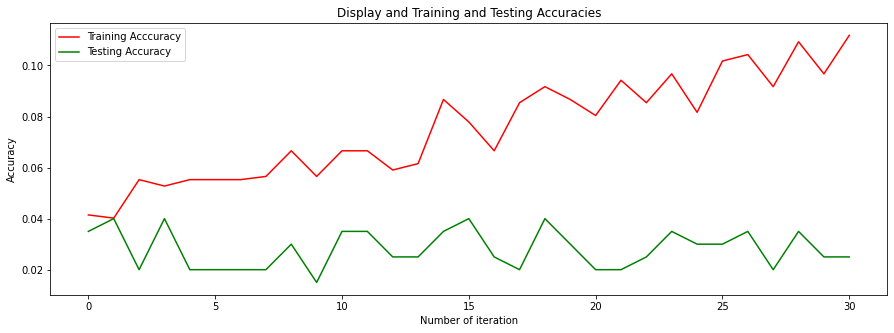

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(train_log, 'r', label ='Training Acccuracy')
plt.plot(test_log, 'g', label ="Testing Accuracy")
plt.xlabel('Number of iteration')
plt.ylabel('Accuracy')
plt.title('Display and Training and Testing Accuracies')
plt.legend(loc = 'best')
plt.show()